## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, git, shutil
skmap_path = './scikit-map'
if False:
    if os.path.exists(skmap_path):
        shutil.rmtree(skmap_path)
    git.Repo.clone_from('https://github.com/openlandmap/scikit-map.git', skmap_path)
from pathlib import Path
sys.path.append('')
sys.path.append(skmap_path)
from skmap.io import process
from skmap.io import RasterData
from rasterio.windows import Window

The data is supposed to be downloaded from [Zenodo](https://zenodo.org/records/8119407) and stored in

In [2]:
data_path = './data'

## Load data

Tiles: ['T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV']

In [3]:

# Parameters
n_ipy = 23 # 16-days images (23 images per year)
tile = 'T22LEH'
n_jobs = 96
win = Window(1600,1600,200,200)
date_step = ([16] * 22) + [13]
try:
    import mkl
    mkl.set_num_threads(n_jobs)
except:
    pass

print(f'Tile {tile}')
# Read the reference data
raser_data_ref = RasterData(
    'data/'+tile+'/reference/HLS.'+tile+'.{dt}.v2.0.NDVI.tif', verbose=False
    ).timespan('2015001', '2022365', 'days', date_step, date_format="%Y%j", ignore_29feb=True, date_style='start_date'
    ).read(n_jobs=n_jobs, window=win)
raser_data_gap = RasterData(
    'data/'+tile+'/artificial_gaps/HLS.'+tile+'.{dt}.v2.0.NDVI_art_gaps.tif', verbose=False
    ).timespan('2015001', '2022365', 'days', date_step, date_format="%Y%j", ignore_29feb=True, date_style='start_date'
    ).read(n_jobs=n_jobs, window=win)
print("--- Filling with SeasConv")
att_seas = 45
att_env = 10
print(f" ------- att_seas {att_seas} , att_env {att_env} ---------")
start_time = time.time()    
n_imag = raser_data_gap.array.shape[2]
conv_vect_future = np.zeros((n_imag,)) # Setting to 0 the weights for future images (the first images should stay gap)
conv_vect_future[0] = 1
raser_seas_conv = RasterData(
    'data/'+tile+'/artificial_gaps/HLS.'+tile+'.{dt}.v2.0.NDVI_art_gaps.tif', verbose=False
    # 'data/'+tile+'/artificial_gaps/HLS.'+tile+'.{dt}.v2.0.NDVI_art_gaps.tif', verbose=False
    ).timespan('2015001', '2022365', 'days', date_step, date_format="%Y%j", ignore_29feb=True, date_style='start_date'
    ).read(n_jobs=n_jobs, window=win
    ).run(process.SeasConvFill(season_size=n_ipy, conv_vect_future=conv_vect_future, att_seas=att_seas, att_env=att_env), drop_input=True)
time_SeasConv = time.time() - start_time
print(f"------ Total time {time_SeasConv:.2f} s")

# Get the indices of the artificial gaps
mask_ref = np.isnan(raser_data_ref.array)
mask_gap = np.isnan(raser_data_gap.array)
mask_art_gap = mask_gap & ~mask_ref
n_art_gap = np.sum(mask_art_gap)



Tile T22LEH
--- Filling with SeasConv
 ------- att_seas 45 , att_env 10 ---------
------ Total time 6.06 s


## Reconstruction

## Visual inspection of the time series reconstruction

In [ ]:
raser_data_ref.animate(cmap='RdYlGn', img_title_text='date')

In [ ]:
raser_data_gap.animate(cmap='RdYlGn', img_title_text='date')

In [ ]:
raser_seas_conv.plot(cmap='RdYlGn', img_title_text='date')

In [ ]:
raser_seas_conv.animate(cmap='RdYlGn', img_title_text='date')

0.029779989887418742


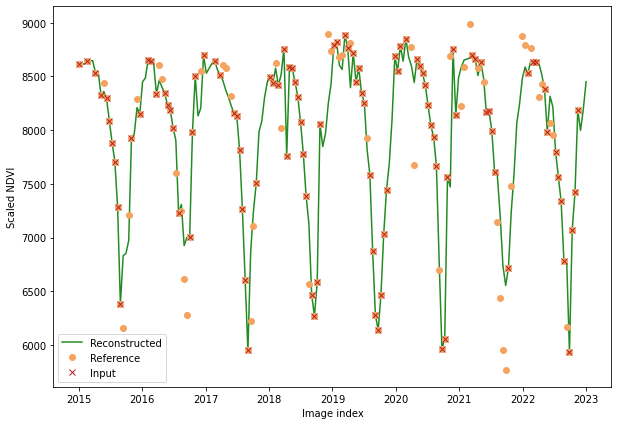

In [4]:

nnan_ref = np.sum(np.isnan(raser_data_ref.array),2)
nnan_gap = np.sum(np.isnan(raser_data_gap.array),2)
nnan_diff = nnan_gap-nnan_ref
idx =  np.unravel_index(np.argmax(nnan_diff), nnan_ref.shape)
pix_x = idx[0]
pix_y = idx[1]
seasconv_ts = raser_seas_conv.array[pix_x,pix_y,:]
gap_ts = raser_data_gap.array[pix_x,pix_y,:]
ref_ts = raser_data_ref.array[pix_x,pix_y,:]
mask = ~np.isnan(ref_ts)
diff = ref_ts[mask] - seasconv_ts[mask]
err = np.linalg.norm(diff)/np.linalg.norm(ref_ts[mask])
print(err)
N = 184
idx = slice(0,N)
plt.figure(figsize=(10,7))
t = np.linspace(2015, 2023, N)
plt.plot(t, seasconv_ts[idx], color = 'forestgreen', label='Reconstructed')
plt.plot(t, ref_ts[idx], 'o', color = 'sandybrown', label='Reference')
plt.plot(t, gap_ts[idx], 'x', color = 'firebrick', label='Input')
plt.legend(loc="lower left")
plt.xlabel('Image index')
plt.ylabel('Scaled NDVI')
plt.savefig('gap_filling_ts.png', dpi=600)
plt.show()

In [5]:
Nimag = 184
seasconv = process.SeasConvFill(season_size=n_ipy, conv_vect_future=conv_vect_future, att_seas=30, att_env=30)

convVec = seasconv._compute_conv_mat_row(Nimag) 
convVecExt = np.zeros(Nimag*2-1)
convVecExt[0:Nimag] = convVec[::-1]
convVecExt[Nimag-1:] = convVec 

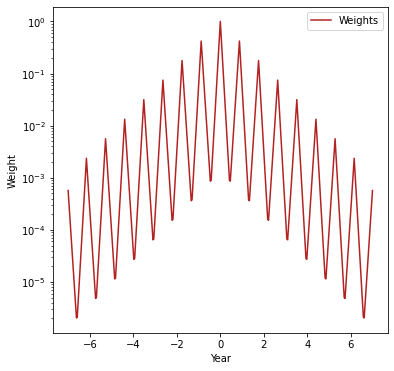

In [6]:

N = 184
plt.figure(figsize=(6,6))
t0 = (np.arange(N*2)-N)
ts = 117
t = np.linspace(-7, 7, 2*N-1)
plt.semilogy(t, convVecExt, color = 'firebrick', label='Weights')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Weight')
plt.savefig('weights_SQAG.png', dpi=600)
plt.show()


(367,)

NameError: name 'convVecPlot' is not defined

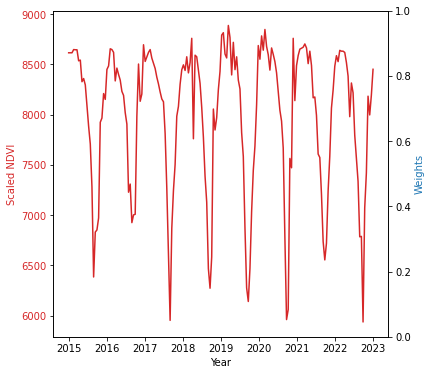

In [10]:
# Create some mock data

fig, ax1 = plt.subplots(figsize=(6,6))

color = 'tab:red'
t = np.linspace(2015, 2023, N)


ax1.set_xlabel('Year')
ax1.set_ylabel('Scaled NDVI', color=color)
ax1.plot(t, seasconv_ts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ran = range()
color = 'tab:blue'
ax2.set_ylabel('Weights', color=color)  # we already handled the x-label with ax1
ax2.plot(t, convVecExt[ran], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('weights_and_TS_SWAG.png', dpi=600)
plt.show()
